### LSST AGN SC Classification Example II

Gordon Richards and Weixiang Yu, Drexel University, May 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.
This example was developed specifically to support Gordon Richards' talk at the AGN SC's meeting-in-a-meeting at the virtual AAS in June 2020.

In [1]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb
import seaborn as sea
from scipy import stats

#So that plots will be displayed inline
%matplotlib inline 

In [2]:
import palettable

#See colorbrewer2.org
#4-class PuOr
#$cmap="PuOr"
cspuor = palettable.colorbrewer.diverging.PuOr_4.mpl_colors

#4-class Dark
csdark = palettable.colorbrewer.qualitative.Dark2_4.mpl_colors

#4-class Paired
cspaired = palettable.colorbrewer.qualitative.Paired_4.mpl_colors

#6-class sequential
cspurples = palettable.colorbrewer.sequential.Purples_6.mpl_colors
csoranges = palettable.colorbrewer.sequential.Oranges_6.mpl_colors
csblues = palettable.colorbrewer.sequential.Blues_6.mpl_colors
csgreens = palettable.colorbrewer.sequential.Greens_6.mpl_colors
csreds = palettable.colorbrewer.sequential.Reds_6.mpl_colors
csgreys = palettable.colorbrewer.sequential.Greys_6.mpl_colors

In [3]:
## If using SciServer
# See Get_started.ipynb

init()

In [4]:
#Setup defaults for plotting

def figsze(hscale, vscale=(np.sqrt(5.0)-1.0)/2.0, fig_width_pt = 800.0):
    """
    Get the fig_width_pt by inserting \the\textwidth into LaTeX document.

    hscale is fraction of text width you want.

    vscale is fraction of hscale (defaults to golden ratio)  
    """
   
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt*hscale   # width in inches
    fig_height = fig_width#*vscale                   # height in inches
    fig_size = [fig_width/2+2,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "axes.linewidth":1.2,               # width of box, 2 is too wide, 1 is too narrow
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 24,               # LaTeX default is 10pt font, font size of axis text label
    "axes.labelpad" : 6,                # Distance between label and axis    
    "axes.formatter.limits":[-99,99],   # use sci notation if log10 of axis range is smaller than first or larger than second.
                                        # GTR: Actually *don't* -- should change the axis label instead.  E.g., "Flux Density (10^-17 ergs/s/cm^2)" 
                                        # This is a hack b/c there doesn't seem to be an rcParams version of
                                        # axes.ticklabel_format(style='plain')
    #"axes.formatter.style":"plain",    # Turn off multiplicative offsets (sci notation) to the axes [GTR: Doesn't work]
    "axes.formatter.useoffset":False,   # Turn off additive offsets to the axes
    "font.size": 24,
    "legend.fontsize": 24,              # Make the legend/label fonts a little smaller
    "xtick.labelsize": 24,              # Font size of numbers 
    "ytick.labelsize": 24,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
    "xtick.major.top":True,
    "xtick.minor.top":True,
    "ytick.major.right":True,
    "ytick.minor.right":True,
    'xtick.major.width':1.0, 
    'xtick.minor.width':1.0, 
    'ytick.major.width':1.0, 
    'ytick.minor.width':1.0, 
    'xtick.major.size':8,             # size of tickmarks in points
    'xtick.minor.size':4, 
    'ytick.major.size':8, 
    'ytick.minor.size':4,
    'xtick.major.pad':8,               # distance between box and numbers
    'ytick.major.pad':8,
    "figure.figsize": figsze(1,1),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts because your computer can handle it
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

mpl.rcParams.update(pgf_with_latex)

In [5]:
#Define function that will be used to make plot similar to scatter_dot in SM

def contour_scatter(x, y, exkernel=None, ax=None, color='C0', cmap='Blues_r',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    cmap=cmap,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y, color=color, **kwargs_plot)

    if exkernel is False:
        return kernel

    return ax  # x[~x.mask], y[~y.mask]


In [6]:
#Define function that will be used to make plot similar to scatter_dot in SM
#This version plots contours in just one color

def contour_scatter2(x, y, exkernel=None, ax=None, color='C0',
                    lims=None, levels=None, scatter=True, nlevel=1,
                    kwargs_contour={},
                    kwargs_plot={}):
    """ Contour and scatter plot with no points inside contours """


    if ax is None:
        ax = plt.gca()
    # fig, ax = plt.subplots(1)
    if lims is None:
        xmin = x.min()
        xmax = x.max()
        ymin = y.min()
        ymax = y.max()
    else:
        xmin, xmax, ymin, ymax = lims

    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    CS = ax.contour(X,
                    Y,
                    Z,
                    colors=color,
                    levels=levels,
                    **kwargs_contour)

    if scatter is True:
        print(CS.levels)
        threshold = CS.levels[nlevel] # nlevel=1 or 0 depending on Python version?
        z = kernel(values)

        # mask points above density threshold
        x = np.ma.array(x)
        y = np.ma.array(y)
        if exkernel:
            exz = exkernel(values)
            x[exz > threshold] = np.ma.masked
            y[exz > threshold] = np.ma.masked

        x[z > threshold] = np.ma.masked
        y[z > threshold] = np.ma.masked

        ax.scatter(x, y, color=color, **kwargs_plot)

    if exkernel is False:
        return kernel

    return ax  # x[~x.mask], y[~y.mask]

Start by loading up the quasar and non-AGN databases into [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [7]:
qso_df = get_qso_cat()
qso_df.head(3)

,train_id,ra,dec,z,z_err,thing_id,specobjid,spec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,0,310.0377,-1.005592,2.167268,0.000676,<NA>,276352159556042752,7,8647475119809364088,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244397,0.177257,0.134408,0.095297,6,206,0.083856,19.312095,18.875304,18.513243,18.263452,18.025003,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605912576,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,6401869206833334272,NaN,NaN,23.184412,0.436260,1.696868,0.0,0.436792,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848,-0.609215,-0.206735,0.225240,55,qso
1,3,311.6088,0.393812,0.333015,0.000351,<NA>,537282917827608576,7,8647475121420632840,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,3,206,0.051798,19.489293,18.512125,17.722814,17.683700,16.975958,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,2468467513536552960,21.218325,0.06131,21.052940,0.047003,0.742009,0.0,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829,0.044235,0.075344,-0.149525,63,qso
2,4,312.3636,0.718380,1.699121,0.000973,<NA>,314071864353751040,7,8647475121957832451,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,3,206,0.154056,21.131835,20.595028,20.152444,19.718245,19.668558,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360380928,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902,-0.776679,0.635052,-0.486411,47,qso


In [8]:
vstar_df = get_var_cat()
vstar_df.head(3)

,train_id,ivz_id,ra,dec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,specobjid,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,100012,7906731,37.49921,1.248179,8647475122531991636,0.018714,0.003049,0.003790,0.005687,0.019610,0.125279,0.092179,0.066856,0.050695,0.035943,6,0,206,0.080803,20.872561,19.853071,19.798564,19.817875,19.853337,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.080648,2501387338283191808,-1.088944,0.509479,-0.63834,1.135483,-1.290321,0.843259,3785207454586900992,NaN,NaN,22.384655,0.173528,0.940821,0.0,1.019490,0.054507,-0.019311,-0.035462,15652.252822,16248.984216,43707.649029,42931.448916,4.215728e+04,-0.63834,-1.290321,-1.088944,64,vStar
1,100016,7907235,337.49950,1.230992,8647475122505712198,0.033394,0.001987,0.000994,0.000829,0.001670,0.414332,0.304861,0.221111,0.167662,0.118874,6,0,206,0.060045,21.113058,18.763849,17.449119,16.766768,16.391656,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229563,2702582302420520960,1.326021,0.155768,16.47697,0.339029,-1.713997,0.261593,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,2.349210,1.314730,0.682351,0.375113,12535.479466,13017.556004,380520.448083,713376.049325,1.026504e+06,16.47697,-1.713997,1.326021,62,vStar
2,100017,7907288,337.49980,-0.002995,8647475120895099460,0.031712,0.004624,0.003833,0.004397,0.014379,0.368637,0.271240,0.196725,0.149171,0.105764,6,0,206,0.019169,21.165513,20.076470,19.583955,19.429559,19.355206,337.499836,-0.002989,620326,14.699725,2.305519,14.990035,2.25308,0.269771,0.01114,0.130273,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,1.089043,0.492516,0.154395,0.074353,11942.406820,12402.802438,53261.744502,61397.889774,6.686797e+04,NaN,NaN,NaN,113,vStar


Actually, better yet, let's load both the quasars and non-AGNs into a single DataFrame, where the class is indicated by `class`. (**qso**, **vStar** and **gal**)  This will make our lives easier in terms of getting the training data into the format that [SciKit-Learn](https://scikit-learn.org/stable/index.html) prefers.

In [9]:
# select only qso and vStar
all_df = get_train_cat()
all_df = all_df[all_df['class'] !='gal']
all_df.head(5)

,class,class_star_ch1,class_star_ch2,dec,dec_sp,dered_g,dered_i,dered_r,dered_u,dered_z,extinction_g,extinction_i,extinction_r,extinction_u,extinction_z,flux_auto_ch1,flux_auto_ch2,fluxerr_auto_ch1,fluxerr_auto_ch2,fuv_mag,fuv_magerr,gaia_id,galex_id,ivz_id,lcN,mpstype,nuv_mag,nuv_magerr,parallax,parallax_error,pmdec,pmdec_error,pmra,pmra_error,psFlux[g],psFlux[i],psFlux[r],psFlux[u],psFlux[z],psParallax,psPm[0],psPm[1],psfmagerr_g,psfmagerr_i,psfmagerr_r,psfmagerr_u,psfmagerr_z,ra,ra_sp,run,sdss_objid,spec,spec_subclass,specobjid,spies_id,src2gaia,src2galex,src2photo,src2spies,stdColor[0],stdColor[1],stdColor[2],stdColor[3],thing_id,train_id,type,z,z_err
0,qso,NaN,NaN,-1.005592,NaN,18.875304,18.263452,18.513243,19.312095,18.025003,0.244397,0.134408,0.177257,0.332155,0.095297,NaN,NaN,NaN,NaN,NaN,NaN,4226318531605912576,6401869206833334272,<NA>,55,0.0,23.184412,0.436260,0.225240,0.283972,-0.206735,0.305267,-0.609215,0.464463,68419.255122,179737.984132,142798.907734,65942.328054,228014.565848,0.225240,-0.609215,-0.206735,0.003265,0.002969,0.003569,0.008446,0.005960,310.0377,NaN,206,8647475119809364088,7,NaN,276352159556042752,<NA>,0.024083,1.696868,0.083856,NaN,0.436792,0.362060,0.249792,0.238449,<NA>,0,6,2.167268,0.000676
1,qso,NaN,NaN,0.393812,NaN,18.512125,17.683700,17.722814,19.489293,16.975958,0.364045,0.200210,0.264036,0.494767,0.141952,NaN,NaN,NaN,NaN,21.218325,0.061310,4228017414511443968,2468467513536552960,<NA>,63,0.0,21.052940,0.047003,-0.149525,0.160723,0.075344,0.179892,0.044235,0.275073,58115.957521,306580.434350,295732.889174,56011.332155,599285.639829,-0.149525,0.044235,0.075344,0.001996,0.002298,0.001869,0.011383,0.003088,311.6088,NaN,206,8647475121420632840,7,NaN,537282917827608576,<NA>,0.092993,0.742009,0.051798,NaN,0.977168,0.789311,0.039115,0.707741,<NA>,3,3,0.333015,0.000351
2,qso,NaN,NaN,0.718380,NaN,20.595028,19.718245,20.152444,21.131835,19.668558,0.387692,0.213215,0.281186,0.526905,0.151172,NaN,NaN,NaN,NaN,NaN,NaN,4228378535360380928,<NA>,<NA>,47,NaN,NaN,NaN,-0.486411,0.729782,0.635052,1.033818,-0.776679,2.051325,12794.084912,47059.204593,31547.575429,12319.895839,50039.124902,-0.486411,-0.776679,0.635052,0.009041,0.007637,0.007869,0.037532,0.022191,312.3636,NaN,206,8647475121957832451,7,NaN,314071864353751040,<NA>,0.218568,NaN,0.154056,NaN,0.536807,0.442585,0.434199,0.049687,<NA>,4,3,1.699121,0.000973
3,qso,NaN,NaN,0.834625,NaN,20.042354,19.652183,19.884427,20.403761,19.501243,0.382986,0.210627,0.277773,0.520510,0.149337,NaN,NaN,NaN,NaN,22.338091,0.160893,<NA>,2468502697908636672,<NA>,108,0.0,21.475634,0.056155,NaN,NaN,NaN,NaN,NaN,NaN,25029.261444,50012.543099,40383.598908,24118.091101,58422.366330,NaN,NaN,NaN,0.005620,0.007393,0.006083,0.020328,0.019640,312.4020,NaN,206,8647475121957831705,7,NaN,314071864311808000,<NA>,NaN,0.364936,0.160105,NaN,0.361406,0.157927,0.232244,0.150940,<NA>,5,3,0.475306,0.000354
4,qso,NaN,NaN,0.455123,NaN,20.005581,19.760675,19.965770,19.954390,19.543730,0.338089,0.185935,0.245210,0.459490,0.131831,NaN,NaN,NaN,NaN,NaN,NaN,4228358022596119040,2468537882278632960,<NA>,50,0.0,23.030893,0.171892,0.250211,0.772921,-0.107082,1.024258,1.965712,2.234255,37865.005535,45254.921252,37467.915153,36491.532269,56170.337863,0.250211,1.965712,-0.107082,0.005312,0.007587,0.006064,0.013942,0.019144,312.4340,NaN,106,8647474692461166737,7,NaN,314353417491316736,<NA>,0.100156,0.508715,0.150507,NaN,-0.051192,0.039811,0.205095,0.216945,<NA>,6,6,2.080289,0.001066


What columns are available to us?  And how many non-null entries are there for each feature?

In [10]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49528 entries, 0 to 158803
Data columns (total 68 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   class             49528 non-null  object 
 1   class_star_ch1    7809 non-null   float64
 2   class_star_ch2    7809 non-null   float64
 3   dec               49528 non-null  float64
 4   dec_sp            7809 non-null   float64
 5   dered_g           49528 non-null  float64
 6   dered_i           49528 non-null  float64
 7   dered_r           49528 non-null  float64
 8   dered_u           49528 non-null  float64
 9   dered_z           49528 non-null  float64
 10  extinction_g      49528 non-null  float64
 11  extinction_i      49528 non-null  float64
 12  extinction_r      49528 non-null  float64
 13  extinction_u      49528 non-null  float64
 14  extinction_z      49528 non-null  float64
 15  flux_auto_ch1     7809 non-null   float64
 16  flux_auto_ch2     7809 non-null   float

Note that the different features/attributes/columns in the dataframe have different numbers of non-null entries.  One has to decide how to handle these.  Either by dropping objects with nulls, dropping columns with too many nulls, or replacing the null values with some sort of average (so that that objects or column can still be used even if that feature is not accurate).

Note also the use of `stdColor[0]` etc, which is the way that "colors" are stored in the current [LSST Data Model](https://lse-163.lsst.io/).  Unfortunately, one of the few downsides of Pandas is that it can't handle vectors columns like this, so they are currently split up in a way that is somewhat awkward.

#### Colors compared to Colors+Proper Motion
Let's do an example where we combine data from different sources (limiting the number of objects with all the parameters) and see how selection compares between using colors alone and colors plus another parameter (here proper motion).

In [11]:
collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','parallax','pmra','pmdec','class']
train_df = all_df[collist]

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49528 entries, 0 to 158803
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           49528 non-null  float64
 1   dec          49528 non-null  float64
 2   stdColor[0]  49528 non-null  float64
 3   stdColor[1]  49528 non-null  float64
 4   stdColor[2]  49528 non-null  float64
 5   stdColor[3]  49528 non-null  float64
 6   parallax     33543 non-null  float64
 7   pmra         33543 non-null  float64
 8   pmdec        33543 non-null  float64
 9   class        49528 non-null  object 
dtypes: float64(9), object(1)
memory usage: 4.2+ MB


That still leaves us with some features with null values.  For now, let's drop those objects.  [Other options](https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html) are also available.

In [13]:
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33543 entries, 0 to 158803
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ra           33543 non-null  float64
 1   dec          33543 non-null  float64
 2   stdColor[0]  33543 non-null  float64
 3   stdColor[1]  33543 non-null  float64
 4   stdColor[2]  33543 non-null  float64
 5   stdColor[3]  33543 non-null  float64
 6   parallax     33543 non-null  float64
 7   pmra         33543 non-null  float64
 8   pmdec        33543 non-null  float64
 9   class        33543 non-null  object 
dtypes: float64(9), object(1)
memory usage: 2.8+ MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  "y" are the classes for each of those objects.
We'll next build both "y" and "X" (the order is important) from our training dataframe.  
"y" is just the values of `class`.  Note that Pandas dataframes have meta data associated with them.  Using the `values` attribute extracts just the numbers, which is what SciKit-Learn wants.
Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Note that we haven't dropped the RA and Dec from X.  They probably aren't that useful, but they shouldn't hurt either.

In [14]:
y = train_df['class'].values.copy()
y

array(['qso', 'qso', 'qso', ..., 'vStar', 'vStar', 'vStar'], dtype=object)

Create masks to pull out the stars and quasars separately, and count how many of each we have left after the null values were dropped.

In [15]:
starmask = (y=='vStar')
qsomask = (y=='qso')
print(starmask.sum())
print(qsomask.sum())

23422
10121


Before we do any sort of selection, let's plot the colors of the stars and quasars to see where they overlap and where they don't.

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0. 1. 2. 3. 4. 5. 6. 7.]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


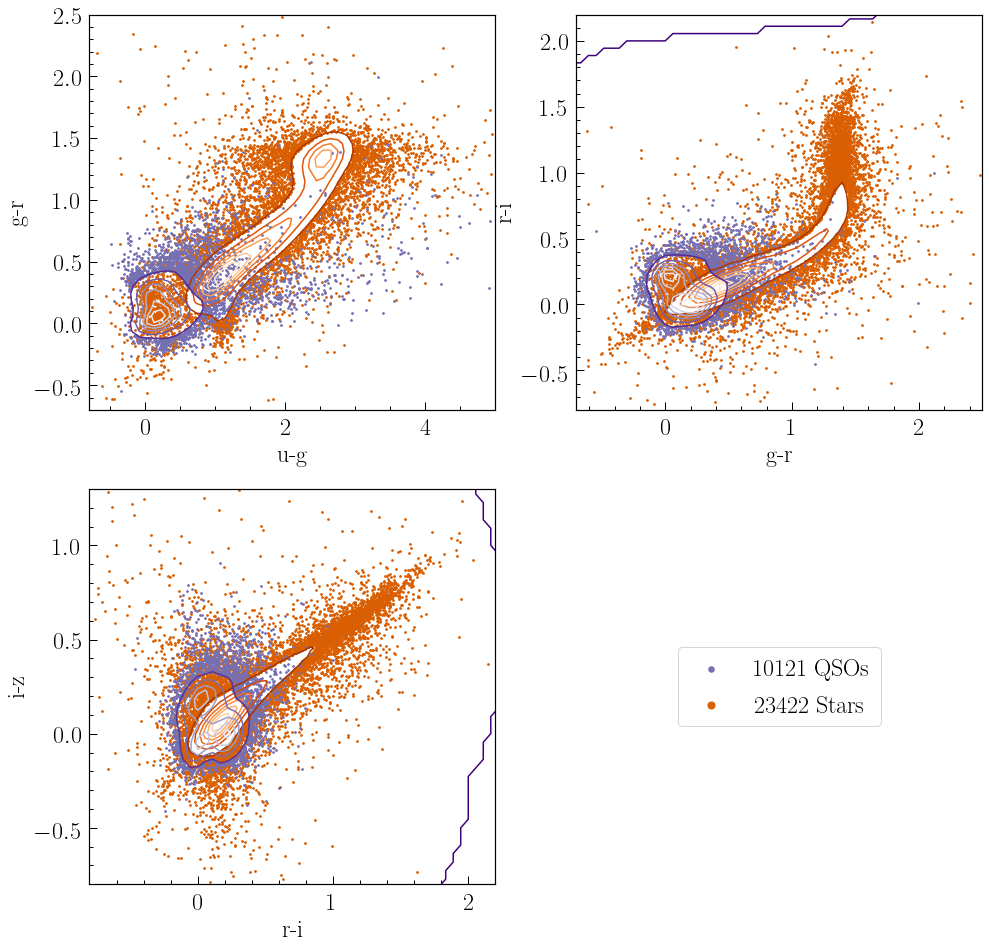

In [16]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsgri2 = np.array([[-2,2], [-2,2]])
limsgri2 = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[starmask]['stdColor[0]'], train_df[starmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[0]'], train_df[qsomask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        #axis.set_yticks(rotation=90)
        
    if i==1:
        contour_scatter(train_df[starmask]['stdColor[1]'], train_df[starmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[1]'], train_df[qsomask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[starmask]['stdColor[2]'], train_df[starmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[qsomask]['stdColor[2]'], train_df[qsomask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=50)]
        labels  = [str(qsomask.sum())+' QSOs',str(starmask.sum())+' Stars']
        legend = axis.legend(handles, labels, loc='center')    
        
plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colors.png')        

It is important for us to realize that the "stars" within the main QSO contours are very likely to be QSOs.  The issue is that we don't have spectra of everything and the stars were selected to be variable.  So the majority of the objects in the region dominated by quasars are very likely to be quasars and will need to be handled carefully.  This is one of the challenges of developing a training set where there are no definitive truth tables.

---

Ignoring the contamination of QSOs in the stars sample, let's start by seeing how well a RF does at classification using colors alone.

In [17]:
Xcolors = train_df.drop(['class', 'ra', 'dec', 'parallax', 'pmra', 'pmdec'],axis=1).values
Xcolors
print(Xcolors.shape)

(33543, 4)


In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
#Instantiate a model with the parameters we decide upon.
model = RandomForestClassifier(n_estimators=50)

In [20]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scoresColors=cross_val_score(model, Xcolors, y, cv=5)
scoresColors.mean()

0.935605808305098

In [21]:
#Get actual predicted values so that we can make plots
from sklearn.model_selection import cross_val_predict
ypredColors = cross_val_predict(model, Xcolors, y, cv=5)

In [22]:
from sklearn.metrics import confusion_matrix
tp, fn, fp, tn = confusion_matrix(y,ypredColors).ravel()
print(tp, tn, fp, fn)

9236 22143 1279 885


In [23]:
#Make masks for the above to aid in plotting
tpmask = ((y=='qso') & (ypredColors=='qso'))
tnmask = ((y=='vStar') & (ypredColors=='vStar'))
fpmask = ((y=='vStar') & (ypredColors=='qso'))
fnmask = ((y=='qso') & (ypredColors=='vStar'))
print(tpmask.sum(),tnmask.sum(),fpmask.sum(),fnmask.sum())

9236 22143 1279 885


In [24]:
from sklearn.metrics import classification_report
target_names=np.unique(train_df['class'])
print(classification_report(y, ypredColors, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.88      0.91      0.90     10121
       vStar       0.96      0.95      0.95     23422

    accuracy                           0.94     33543
   macro avg       0.92      0.93      0.92     33543
weighted avg       0.94      0.94      0.94     33543



Now make plots of the results.

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8]
[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0. 1. 2. 3. 4. 5. 6. 7.]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]


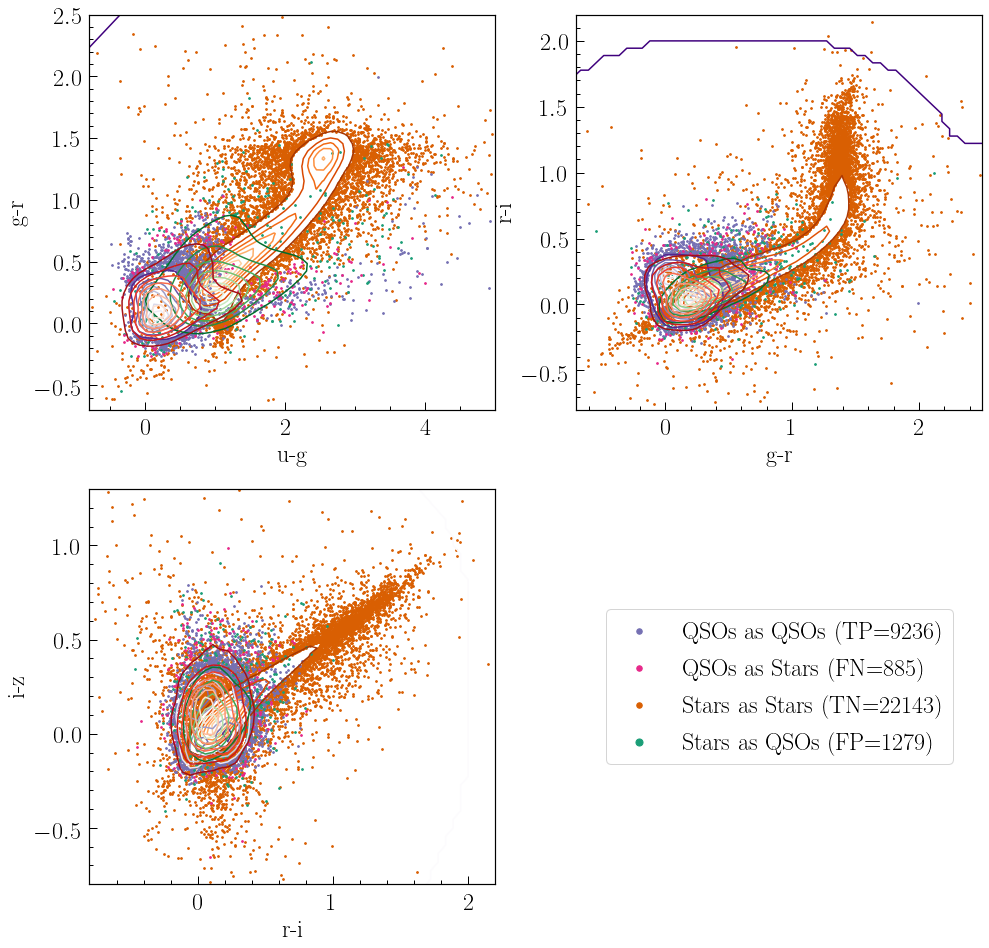

In [25]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[tnmask]['stdColor[0]'], train_df[tnmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[0]'], train_df[tpmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'],color=csdark[0],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'],color=csdark[3],s=3)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[tnmask]['stdColor[1]'], train_df[tnmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[1]'], train_df[tpmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'],color=csdark[0],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'],color=csdark[3],s=3)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[tnmask]['stdColor[2]'], train_df[tnmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask]['stdColor[2]'], train_df[tpmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[0],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[3],s=3)
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TN='+str(tnmask.sum())+')', 'QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask.sum())+')', 'QSOs as Stars (FN='+str(fnmask.sum())+')', 'Stars as Stars (TN='+str(tnmask.sum())+')', 'Stars as QSOs (FP='+str(fpmask.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colorsonly.png')  

Note that the number of false positives is misleading as many of those are likely to be real quasars.  But what really seems to be happening is that real quasars are being classified as stars (FN) because there are QSOs in the stars training set, making real QSOs get classified as stars.

Now add the GAIA proper motion data

In [26]:
X2 = train_df.drop(['class', 'ra', 'dec'],axis=1).values
X2
print(X2.shape)

(33543, 7)


In [27]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scores2=cross_val_score(model, X2, y, cv=5)
scores2.mean()

0.9456826033044372

In [28]:
#Get actual predicted values so that we can make plots
ypred2 = cross_val_predict(model, X2, y, cv=5)

In [29]:
from sklearn.metrics import confusion_matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y,ypred2).ravel()
print(tn2, fp2, fn2, tp2)

9455 666 1145 22277


In [30]:
#Make masks for the above to aid in plotting
tpmask2 = ((y=='qso') & (ypred2=='qso'))
tnmask2 = ((y=='vStar') & (ypred2=='vStar'))
fpmask2 = ((y=='vStar') & (ypred2=='qso'))
fnmask2 = ((y=='qso') & (ypred2=='vStar'))

In [31]:
target_names=np.unique(train_df['class'])
print(classification_report(y, ypred2, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.89      0.93      0.91     10121
       vStar       0.97      0.95      0.96     23422

    accuracy                           0.95     33543
   macro avg       0.93      0.94      0.94     33543
weighted avg       0.95      0.95      0.95     33543



[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8]
[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05 1.2 ]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[ 0.   1.5  3.   4.5  6.   7.5  9.  10.5 12. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]


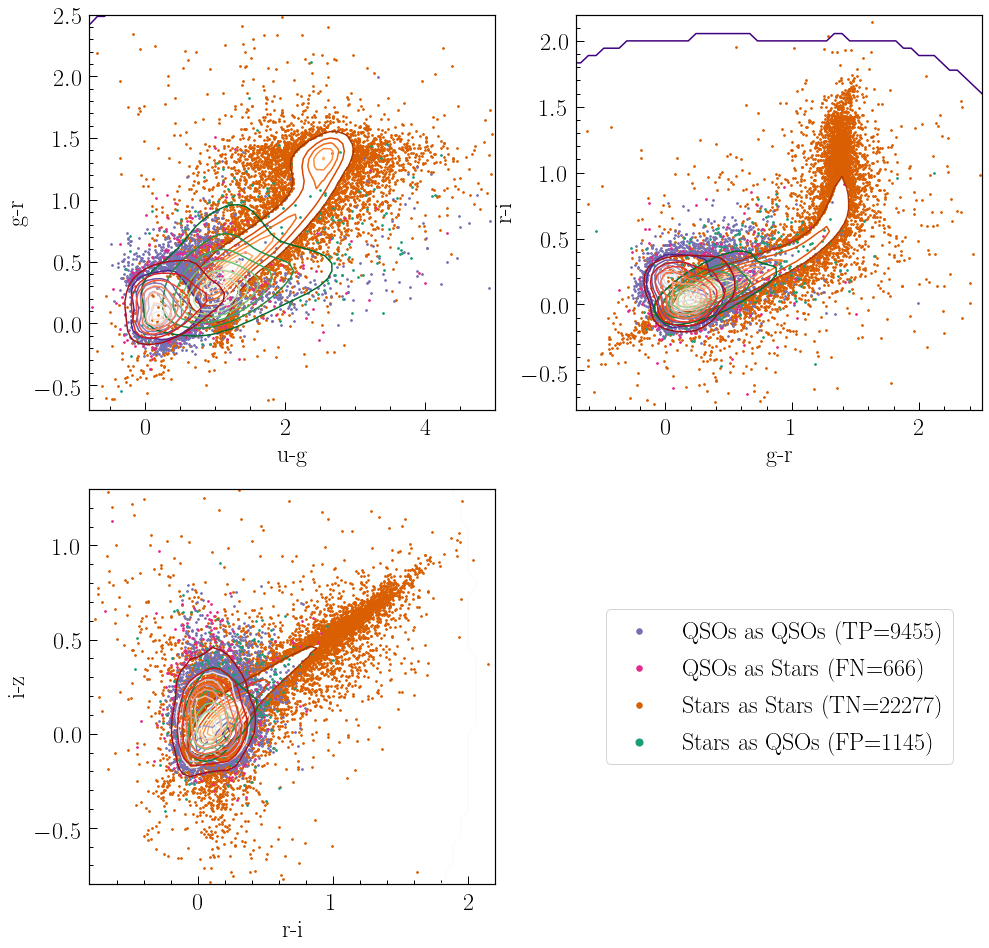

In [32]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_df[tnmask2]['stdColor[0]'], train_df[tnmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[0]'], train_df[tpmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[0]'], train_df[fnmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[0]'], train_df[fpmask2]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_df[tnmask2]['stdColor[1]'], train_df[tnmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[1]'], train_df[tpmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fnmask2]['stdColor[1]'], train_df[fnmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[1]'], train_df[fpmask2]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'],color=csdark[0],s=3)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_df[tnmask2]['stdColor[2]'], train_df[tnmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[tpmask2]['stdColor[2]'], train_df[tpmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_df[fnmask2]['stdColor[2]'], train_df[fnmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_df[fpmask2]['stdColor[2]'], train_df[fpmask2]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TP='+str(tnmask2.sum())+')', 'QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as Stars (TN='+str(tnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
        legend = axis.legend(handles, labels, loc='center')    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colorsandpm.png')  

These results are better as one might expect from adding new information.  But we are still hindered by the errors in the training set itself.

That's the colors, but what does a plot of the proper motions look like?

In [33]:
#This probably isn't right, but computing it this way as a placeholder
#Does it need cos(dec)?
train_df['pm'] = np.sqrt(train_df['pmra']*train_df['pmra'] + train_df['pmdec']*train_df['pmdec'])

[0.    0.008 0.016 0.024 0.032 0.04  0.048 0.056]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]
[0.    0.015 0.03  0.045 0.06  0.075 0.09 ]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


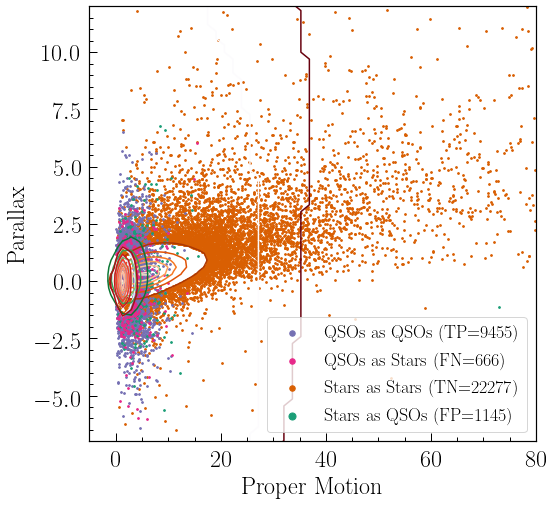

In [34]:
lims = np.array([[-10,150], [-10,20]])
lims = lims.flatten()
levels = None
#levels = [10, 50, 90]
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, axis = plt.subplots(1,1,figsize=(8,8))


handles, labels = (0, 0)

contour_scatter(train_df[tnmask2]['pm'], train_df[tnmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(train_df[tpmask2]['pm'], train_df[tpmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
contour_scatter(train_df[fnmask2]['pm'], train_df[fnmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
contour_scatter(train_df[fpmask2]['pm'], train_df[fpmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[3],s=3)
#axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[0],s=3)
        
#contour_scatter(train_df[tnmask2]['pm'], train_df[tnmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Reds_r', color='red', kwargs_plot={'rasterized':True, 's':2}, ax=axis)
#contour_scatter(train_df[tpmask2]['pm'], train_df[tpmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Blues_r', color='blue', kwargs_plot={'rasterized':True, 's':2}, ax=axis)
#contour_scatter(train_df[fpmask2]['pm'], train_df[fpmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Oranges_r', color='orange', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#contour_scatter(train_df[fnmask2]['pm'], train_df[fnmask2]['parallax'], lims=lims, levels=levels, nlevel=nlevel, cmap='Purples_r', color='purple', kwargs_plot={'rasterized':True, 's':3}, ax=axis)
#axis.scatter(train_df[fpmask2]['pm'], train_df[fpmask2]['parallax'],color='cyan',s=3)
#axis.scatter(train_df[fnmask2]['pm'], train_df[fnmask2]['parallax'],color='orange',s=3)
axis.set_xlim(-5,80)
axis.set_ylim(-7,12)
axis.set_xlabel('Proper Motion')
axis.set_ylabel('Parallax')

#axis.set_axis_off()
#handles = [plt.scatter([], [], color='red', s=30),plt.scatter([],[],color='blue',s=30),plt.scatter([],[],color='cyan',s=30),plt.scatter([],[],color='orange',s=30)]
#handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
#labels  = ['Stars as Stars (TP='+str(tnmask2.sum())+')', 'QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
labels  = ['QSOs as QSOs (TP='+str(tpmask2.sum())+')', 'QSOs as Stars (FN='+str(fnmask2.sum())+')', 'Stars as Stars (TN='+str(tnmask2.sum())+')', 'Stars as QSOs (FP='+str(fpmask2.sum())+')']
legend = axis.legend(handles, labels, loc='best', fontsize=18)    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colorsandpm_pmplot.png')  

Note that the PM will help identify stars that might be mistaken as quasars, but not the other way around.  So, this won't help with the problem noted above.

#### Optical Colors compared to Optical+IR Colors
Now see what happens if we add IR colors.  Note that this significantly reduces the size of the data set.

In [35]:
#collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','parallax','pmra','pmdec','class']
collistIR = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','psFlux[z]','flux_auto_ch1','flux_auto_ch2','class']
train_dfIR = all_df[collistIR]

In [36]:
train_dfIR = train_dfIR.dropna()
train_dfIR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7809 entries, 260 to 157296
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ra             7809 non-null   float64
 1   dec            7809 non-null   float64
 2   stdColor[0]    7809 non-null   float64
 3   stdColor[1]    7809 non-null   float64
 4   stdColor[2]    7809 non-null   float64
 5   stdColor[3]    7809 non-null   float64
 6   psFlux[z]      7809 non-null   float64
 7   flux_auto_ch1  7809 non-null   float64
 8   flux_auto_ch2  7809 non-null   float64
 9   class          7809 non-null   object 
dtypes: float64(9), object(1)
memory usage: 671.1+ KB


In [37]:
train_dfIR['zch1'] = (22.5-np.log10(train_dfIR['psFlux[z]'])) - (22.5-np.log10(train_dfIR['flux_auto_ch1']))
train_dfIR['zch1']

260      -2.691143
264      -2.867188
266      -2.528995
269      -2.613829
271      -2.559659
            ...   
157281   -3.683252
157283   -3.392663
157294   -2.735292
157295   -3.256453
157296   -3.045517
Name: zch1, Length: 7809, dtype: float64

In [38]:
train_dfIR['ch1ch2'] = (22.5-np.log10(train_dfIR['flux_auto_ch1'])) - (22.5-np.log10(train_dfIR['flux_auto_ch2']))
train_dfIR['ch1ch2']

260       0.139384
264       0.178995
266       0.224344
269       0.193860
271       0.142449
            ...   
157281   -0.173232
157283   -0.196511
157294   -0.157793
157295   -0.194475
157296   -0.201967
Name: ch1ch2, Length: 7809, dtype: float64

In [39]:
yIR = train_dfIR['class'].values.copy()
yIR

array(['qso', 'qso', 'qso', ..., 'vStar', 'vStar', 'vStar'], dtype=object)

In [40]:
XIR = train_dfIR.drop(['class','psFlux[z]','flux_auto_ch1','flux_auto_ch2'],axis=1).values
XIR
print(XIR.shape)

(7809, 8)


In [41]:
#Needed to see how well we do on these objects just using optical colors
XIRoptonly = train_dfIR.drop(['class','psFlux[z]','flux_auto_ch1','flux_auto_ch2','zch1','ch1ch2'],axis=1).values
XIRoptonly
print(XIRoptonly.shape)

(7809, 6)


In [42]:
starmaskIR = (yIR=='vStar')
qsomaskIR = (yIR=='qso')
print(starmaskIR.sum())
print(qsomaskIR.sum())

1877
5932


[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05 1.2 ]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[ 0.  2.  4.  6.  8. 10. 12. 14. 16.]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


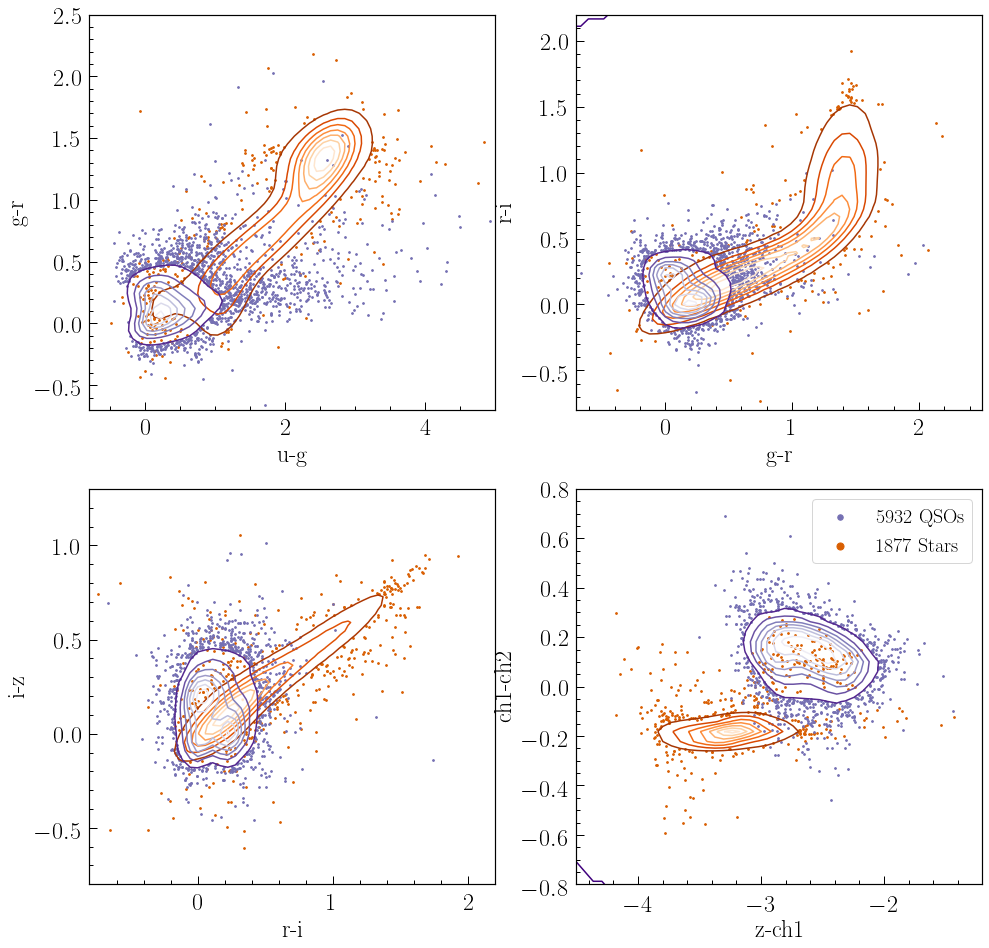

In [43]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
limszch1ch2 = np.array([[-5,2], [-2,2]])
limszch1ch2 = limszch1ch2.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_dfIR[starmaskIR]['stdColor[0]'], train_dfIR[starmaskIR]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[qsomaskIR]['stdColor[0]'], train_dfIR[qsomaskIR]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        #axis.set_yticks(rotation=90)
        
    if i==1:
        contour_scatter(train_dfIR[starmaskIR]['stdColor[1]'], train_dfIR[starmaskIR]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[qsomaskIR]['stdColor[1]'], train_dfIR[qsomaskIR]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_dfIR[starmaskIR]['stdColor[2]'], train_dfIR[starmaskIR]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[qsomaskIR]['stdColor[2]'], train_dfIR[qsomaskIR]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        contour_scatter(train_dfIR[starmaskIR]['zch1'], train_dfIR[starmaskIR]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[qsomaskIR]['zch1'], train_dfIR[qsomaskIR]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        axis.set_xlim(-4.5,-1.2)
        axis.set_ylim(-0.8,0.8)
        axis.set_xlabel('z-ch1')
        axis.set_ylabel('ch1-ch2')     
        
    if i==3:
        #axis.set_axis_off()
        handles = [plt.scatter([], [], color=csdark[2], s=30),plt.scatter([],[],color=csdark[1],s=50)]
        labels  = [str(qsomaskIR.sum())+' QSOs',str(starmaskIR.sum())+' Stars']
        legend = axis.legend(handles, labels, loc='best', fontsize=20)    
        
plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colorsIR.png')    

Here we can see that adding the IR colors really helps!  Indeed, it makes it possible to identify exactly which of the stars are likely to be QSOs.

Let's compare optical-only selection to optical+IR selection.

First, selection based only on optical colors (for objects that have IR data)

In [44]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scoresIRoptonly=cross_val_score(model, XIRoptonly, yIR, cv=5)
scoresIRoptonly.mean()

0.922269204300405

In [45]:
#Get actual predicted values so that we can make plots
ypredIRoptonly = cross_val_predict(model, XIRoptonly, yIR, cv=5)

In [46]:
from sklearn.metrics import confusion_matrix
tn3, fp3, fn3, tp3 = confusion_matrix(yIR,ypredIRoptonly).ravel()
print(tn3, fp3, fn3, tp3)

5636 296 333 1544


In [47]:
#Make masks for the above to aid in plotting
tpmask3 = ((yIR=='qso') & (ypredIRoptonly=='qso'))
tnmask3 = ((yIR=='vStar') & (ypredIRoptonly=='vStar'))
fpmask3 = ((yIR=='vStar') & (ypredIRoptonly=='qso'))
fnmask3 = ((yIR=='qso') & (ypredIRoptonly=='vStar'))

In [48]:
target_names=np.unique(train_df['class'])
print(classification_report(yIR, ypredIRoptonly, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.94      0.95      0.95      5932
       vStar       0.84      0.82      0.83      1877

    accuracy                           0.92      7809
   macro avg       0.89      0.89      0.89      7809
weighted avg       0.92      0.92      0.92      7809



[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05]
[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.6 1.2 1.8 2.4 3.  3.6 4.2 4.8]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  1.5 3.  4.5 6.  7.5 9. ]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[ 0.  3.  6.  9. 12. 15. 18. 21. 24.]
[0. 1. 2. 3. 4. 5. 6. 7.]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8]


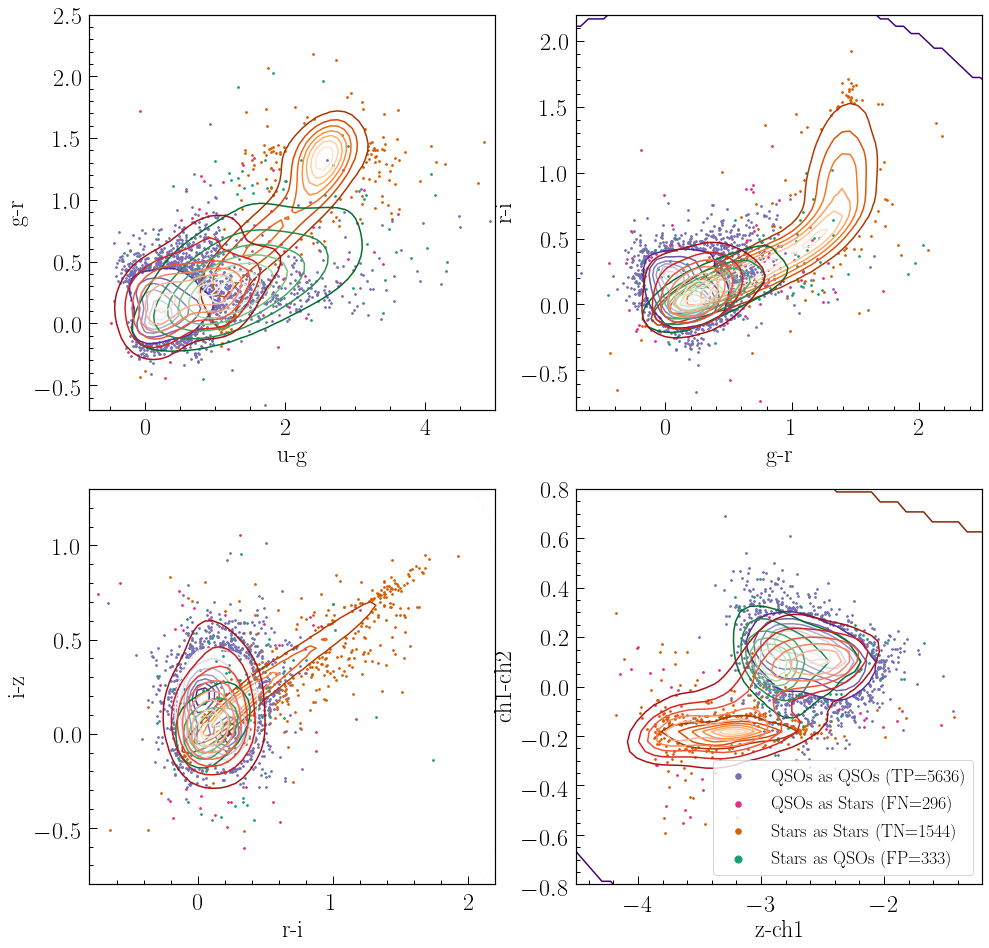

In [49]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_dfIR[tnmask3]['stdColor[0]'], train_dfIR[tnmask3]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask3]['stdColor[0]'], train_dfIR[tpmask3]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fnmask3]['stdColor[0]'], train_dfIR[fnmask3]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask3]['stdColor[0]'], train_dfIR[fpmask3]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_dfIR[tnmask3]['stdColor[1]'], train_dfIR[tnmask3]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask3]['stdColor[1]'], train_dfIR[tpmask3]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fnmask3]['stdColor[1]'], train_dfIR[fnmask3]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask3]['stdColor[1]'], train_dfIR[fpmask3]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'],color=csdark[0],s=3)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_dfIR[tnmask3]['stdColor[2]'], train_dfIR[tnmask3]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask3]['stdColor[2]'], train_dfIR[tpmask3]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_dfIR[fnmask3]['stdColor[2]'], train_dfIR[fnmask3]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask3]['stdColor[2]'], train_dfIR[fpmask3]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        contour_scatter(train_dfIR[tnmask3]['zch1'], train_dfIR[tnmask3]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask3]['zch1'], train_dfIR[tpmask3]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_dfIR[fnmask3]['zch1'], train_dfIR[fnmask3]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask3]['zch1'], train_dfIR[fpmask3]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-4.5,-1.2)
        axis.set_ylim(-0.8,0.8)
        axis.set_xlabel('z-ch1')
        axis.set_ylabel('ch1-ch2')   
        
    if i==3:
        #axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TN='+str(tnmask3.sum())+')', 'QSOs as QSOs (TP='+str(tpmask3.sum())+')', 'QSOs as Stars (FN='+str(fnmask3.sum())+')', 'Stars as QSOs (FP='+str(fpmask3.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask3.sum())+')', 'QSOs as Stars (FN='+str(fnmask3.sum())+')', 'Stars as Stars (TN='+str(tnmask3.sum())+')', 'Stars as QSOs (FP='+str(fpmask3.sum())+')']
        legend = axis.legend(handles, labels, loc='best', fontsize=18)    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colorsIRoptonly.png')  

Most of the Stars classified as QSOs are probably really QSOs, and as above, many of the QSOs classified as stars are because of QSOs hiding in the star training set.

How does that compare when we add IR?

In [50]:
#See what fraction are correct
from sklearn.model_selection import cross_val_score
scoresIR=cross_val_score(model, XIR, yIR, cv=5)
scoresIR.mean()

0.9731068022484685

97% vs 91%, so much better.  But the plot below shows that this can be misleading as we are still incorrectly classifying QSOs as stars.  So, in reality we are probably doing simultaneously better and worse than this.

In [51]:
#Get actual predicted values so that we can make plots
ypredIR = cross_val_predict(model, XIR, yIR, cv=5)

In [52]:
from sklearn.metrics import confusion_matrix
tn4, fp4, fn4, tp4 = confusion_matrix(yIR,ypredIR).ravel()
print(tn4, fp4, fn4, tp4)

5901 31 179 1698


In [53]:
#Make masks for the above to aid in plotting
tpmask4 = ((yIR=='qso') & (ypredIR=='qso'))
tnmask4 = ((yIR=='vStar') & (ypredIR=='vStar'))
fpmask4 = ((yIR=='vStar') & (ypredIR=='qso'))
fnmask4 = ((yIR=='qso') & (ypredIR=='vStar'))

In [54]:
target_names=np.unique(train_df['class'])
print(classification_report(yIR, ypredIR, target_names=target_names))

              precision    recall  f1-score   support

         qso       0.97      0.99      0.98      5932
       vStar       0.98      0.90      0.94      1877

    accuracy                           0.97      7809
   macro avg       0.98      0.95      0.96      7809
weighted avg       0.97      0.97      0.97      7809



[0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2]
[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2  ]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.   0.15 0.3  0.45 0.6  0.75 0.9  1.05]
[0.  0.4 0.8 1.2 1.6 2.  2.4 2.8 3.2]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0.  0.3 0.6 0.9 1.2 1.5 1.8 2.1 2.4]
[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[ 0.  3.  6.  9. 12. 15. 18. 21.]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[0.  0.8 1.6 2.4 3.2 4.  4.8 5.6 6.4]


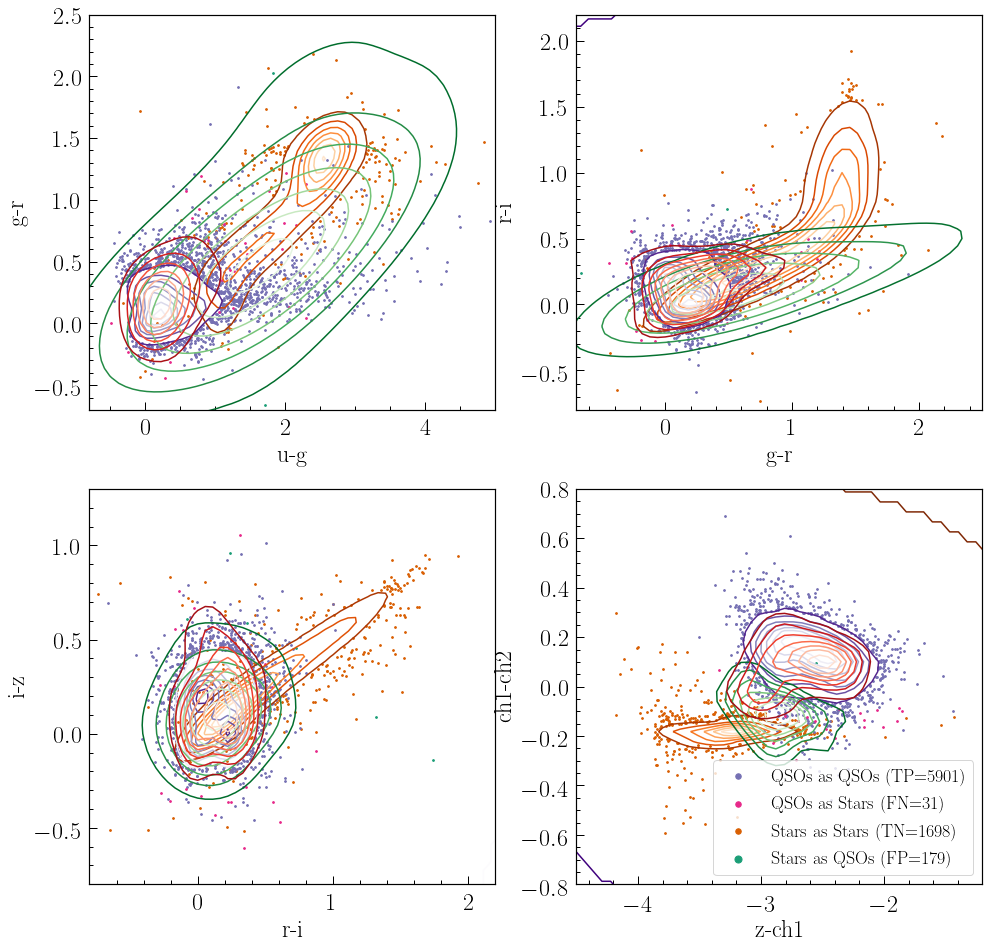

In [55]:
limsugr = np.array([[-2,8], [-2,4]])
limsugr = limsugr.flatten()
limsgri = np.array([[-2,4], [-2,3.5]])
limsgri = limsgri.flatten()
limsriz = np.array([[-2,3.5], [-2,2.5]])
limsriz = limsriz.flatten()
levels = None
nlevel=1

# Make the figure:
#fig,ax = plt.figure(figsize=(8,8))
fig, ax = plt.subplots(2,2,figsize=(16,16))


handles, labels = (0, 0)
    
for i, axis in enumerate(ax.ravel()):

    if i==0: 
        contour_scatter(train_dfIR[tnmask4]['stdColor[0]'], train_dfIR[tnmask4]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask4]['stdColor[0]'], train_dfIR[tpmask4]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fnmask4]['stdColor[0]'], train_dfIR[fnmask4]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask4]['stdColor[0]'], train_dfIR[fpmask4]['stdColor[1]'], lims=limsugr, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[0]'], train_df[fnmask]['stdColor[1]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[0]'], train_df[fpmask]['stdColor[1]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,5)
        axis.set_ylim(-0.7,2.5)
        axis.set_xlabel('u-g')
        axis.set_ylabel('g-r')
        
    if i==1:
        contour_scatter(train_dfIR[tnmask4]['stdColor[1]'], train_dfIR[tnmask4]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask4]['stdColor[1]'], train_dfIR[tpmask4]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fnmask4]['stdColor[1]'], train_dfIR[fnmask4]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask4]['stdColor[1]'], train_dfIR[fpmask4]['stdColor[2]'], lims=limsgri, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[1]'], train_df[fnmask]['stdColor[2]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[1]'], train_df[fpmask]['stdColor[2]'],color=csdark[0],s=3)
        axis.set_xlim(-0.7,2.5)
        axis.set_ylim(-0.8,2.2)
        axis.set_xlabel('g-r')
        axis.set_ylabel('r-i')
        
    if i==2:
        contour_scatter(train_dfIR[tnmask4]['stdColor[2]'], train_dfIR[tnmask4]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask4]['stdColor[2]'], train_dfIR[tpmask4]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Purples', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_dfIR[fnmask4]['stdColor[2]'], train_dfIR[fnmask4]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask4]['stdColor[2]'], train_dfIR[fpmask4]['stdColor[3]'], lims=limsriz, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        #axis.scatter(train_df[fnmask]['stdColor[2]'], train_df[fnmask]['stdColor[3]'],color=csdark[3],s=3)
        #axis.scatter(train_df[fpmask]['stdColor[2]'], train_df[fpmask]['stdColor[3]'],color=csdark[0],s=3)
        axis.set_xlim(-0.8,2.2)
        axis.set_ylim(-0.8,1.3)
        axis.set_xlabel('r-i')
        axis.set_ylabel('i-z')

    if i==3:
        contour_scatter(train_dfIR[tnmask4]['zch1'], train_dfIR[tnmask4]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Oranges_r', color=csdark[1], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[tpmask4]['zch1'], train_dfIR[tpmask4]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Purples_r', color=csdark[2], kwargs_plot={'rasterized':True, 's':3}, ax=axis)  
        contour_scatter(train_dfIR[fnmask4]['zch1'], train_dfIR[fnmask4]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Greens_r', color=csdark[0], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        contour_scatter(train_dfIR[fpmask4]['zch1'], train_dfIR[fpmask4]['ch1ch2'], lims=limszch1ch2, levels=levels, nlevel=nlevel, cmap='Reds_r', color=csdark[3], kwargs_plot={'rasterized':True, 's':3}, ax=axis)
        axis.set_xlim(-4.5,-1.2)
        axis.set_ylim(-0.8,0.8)
        axis.set_xlabel('z-ch1')
        axis.set_ylabel('ch1-ch2')   
        
    if i==3:
        #axis.set_axis_off()
        #handles = [plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([],[],color=csdark[0],s=50)]
        #labels  = ['Stars as Stars (TN='+str(tnmask4.sum())+')', 'QSOs as QSOs (TP='+str(tpmask4.sum())+')', 'QSOs as Stars (FN='+str(fnmask4.sum())+')', 'Stars as QSOs (FP='+str(fpmask4.sum())+')']
        handles = [plt.scatter([],[],color=csdark[2],s=30),plt.scatter([],[],color=csdark[3],s=30),plt.scatter([], [], color=csdark[1], s=30),plt.scatter([],[],color=csdark[0],s=50)]
        labels  = ['QSOs as QSOs (TP='+str(tpmask4.sum())+')', 'QSOs as Stars (FN='+str(fnmask4.sum())+')', 'Stars as Stars (TN='+str(tnmask4.sum())+')', 'Stars as QSOs (FP='+str(fpmask4.sum())+')']
        legend = axis.legend(handles, labels, loc='best', fontsize=18)    

plt.savefig('/home/idies/workspace/Storage/gtr/persistent/plots/MiMstarqso_colorsIRwIR.png')  